
# EMOTIONAL SPEECH ANALYSIS


## English

Luisa Sanchez Avivar
    _luisasanavi@gmail.com_

In [1]:
# IMPORT LIBRARIES
# Analysis
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Files
import os

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils, to_categorical
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
AUDIO_DATA_PATH = 'data/'
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'
SAMPLE_FILE = "03-01-01-01-01-01-01.wav"

# Maps
EMOTION_MAP = {1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
INTENSITY_MAP = {1:'normal', 2:'strong'}


## Carga de datos


<_explicacion detallada del dataset_>



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
dir_list = os.listdir(GPATH + AUDIO_DATA_PATH)
dir_list.sort()

print(dir_list)

emotion = []
gender = []
intensity = []
path = []

# Extraemos de cada archivo de sonido sus datos
for dir in dir_list:
  path_dir = os.listdir(GPATH + AUDIO_DATA_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filepath in path_dir:
    info_vector = filepath.split('.')[0].split('-')
    n_emotion = int(info_vector[2])
    n_gender = int(info_vector[6])
    n_intensity = int(info_vector[3])
    str_path = GPATH + AUDIO_DATA_PATH + dir + '/' + str(filepath)
    path.append(str_path)
    emotion.append(n_emotion)
    intensity.append(n_intensity)
    if n_gender%2 == 0:
      gender.append('female')
    else:
      gender.append('male')

# Construimos el data frame
EnglishSpeech_df = pd.DataFrame(columns=['emotion', 'gender', 'intensity', 'path'])
EnglishSpeech_df['emotion'] = emotion
EnglishSpeech_df['gender'] = gender
EnglishSpeech_df['intensity'] = intensity
EnglishSpeech_df['path'] = path
EnglishSpeech_df['emotion'] = EnglishSpeech_df['emotion'].map(EMOTION_MAP) 
EnglishSpeech_df['intensity'] = EnglishSpeech_df['intensity'].map(INTENSITY_MAP)


print("Size of the dataset: {} \n".format(len(EnglishSpeech_df)))
class_distribution = EnglishSpeech_df['emotion'].value_counts()
print(class_distribution)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
Size of the dataset: 1440 

neutral     288
disgust     192
angry       192
happy       192
sad         192
surprise    192
fear        192
Name: emotion, dtype: int64


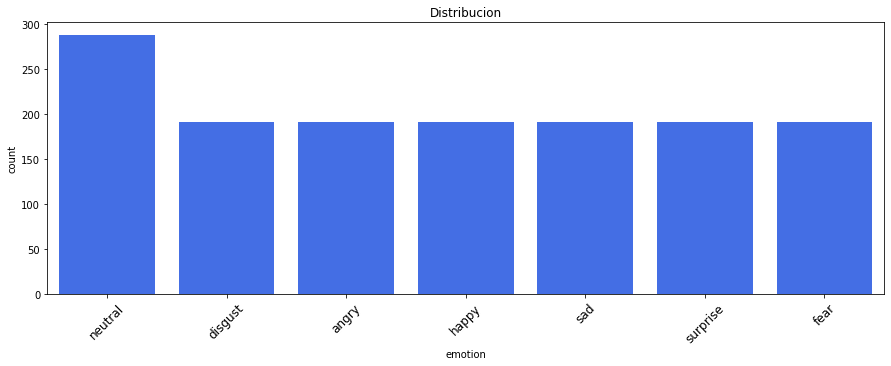

In [6]:
# Imprimimos la distribucion de las clases

df_aux = pd.DataFrame()
df_aux['emotion'] = list(class_distribution.keys())
df_aux['count']  = list(class_distribution)
fig, axs = plt.subplots(figsize=(15, 5))
axs = sns.barplot(x = 'emotion', y = 'count', color = '#2962FF', data = df_aux)
axs.set_title('Distribucion')
axs.set_xticklabels(axs.get_xticklabels(),rotation=45, fontsize = 12)
plt.show()

In [7]:
# Imprimimos una muestra de 10 filas aleatorias
EnglishSpeech_df.sample(n = 10)

,emotion,gender,intensity,path
111,disgust,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
233,disgust,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
982,sad,male,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
470,disgust,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
277,fear,male,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
1406,sad,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
901,neutral,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
706,surprise,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
282,fear,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
1255,surprise,male,strong,/content/drive/My Drive/Master/Asignaturas/2 C...


## Exploracion de los datos

### Exposición de una muestra aleatoria

In [8]:

def plot_audio_waveform(audio_sample):
  sample, sampling_rate = librosa.load(audio_sample)
  plt.figure(figsize=(12, 4))
  librosa.display.waveplot(sample, sr=sampling_rate)
  print(len(sample))
  

def log_specgram(audio_sample):
  sample, sampling_rate = librosa.load(audio_sample)
  return  __log_specgram(sample, sampling_rate)


def __log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


Random audio sample: /content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/data/Actor_17/03-01-02-01-02-01-17.wav
82403


Text(0, 0.5, 'Hz')

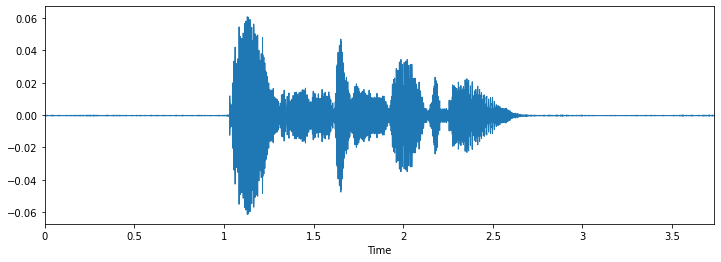

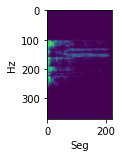

In [9]:
random_sample = EnglishSpeech_df.path[random.randint(0, len(EnglishSpeech_df))]
print("Random audio sample: {}".format(random_sample))
# Plot the audio waveform
plot_audio_waveform(random_sample)

# Plot the spectrogram
freqs, times, spectrogram = log_specgram(random_sample)

# Display the figure
plt.figure(figsize=(30, 2))
plt.imshow(spectrogram)
plt.xlabel('Seg')
plt.ylabel('Hz')

In [10]:

# samplingFrequency, signalData = wavfile.read(random_sample)
# plt.plot(sample)
# plt.specgram(sample, Fs=sampling_rate)

### Comparativa de todas las emociones

In [11]:
def plot_all_emotion_waveforms(gender, rows = 3, cols = 3):
  '''
  Muestra los graficos para todas las emociones con su correspondiente 
  etiqueta del dataset para un mismo genero (female/ male)
  @ Args: 
    gender Genero del actor en el audio
    rows Filas en las que se muestra. 5 por defecto
    cols Columnas en las que se muestra. 2 por defecto
    
  '''
  labels = list(EnglishSpeech_df['emotion'].unique())
  files = dict()
  if not gender:
    return -1

  # Seleccionamos una muestra aleatoria correspondiente a cada emocion
  for label in labels:
    # Escogemos un archivo de audio al azar que cumpla estas dos condiciones
    index = EnglishSpeech_df[(EnglishSpeech_df['emotion'] == label) & 
                            (EnglishSpeech_df['gender'] == gender)].sample(n = 1).index[0]
    emotion_file = EnglishSpeech_df.iloc[index].path
    files[label] = emotion_file

  # Mostramos las diferentes waveforms
  fig = plt.figure(figsize=(15,15))
  fig.subplots_adjust(hspace=1, wspace=0.4)
  for i, label in enumerate(labels):
    wfigure = files[label]
    fig.add_subplot(rows, cols, i+1)
    plt.title(label.capitalize())
    data_sample, sample_rate = librosa.load(wfigure)
    librosa.display.waveplot(data_sample, sr= sample_rate)

    ## TODO: return image figure


### Comparativa de emociones  para hombre

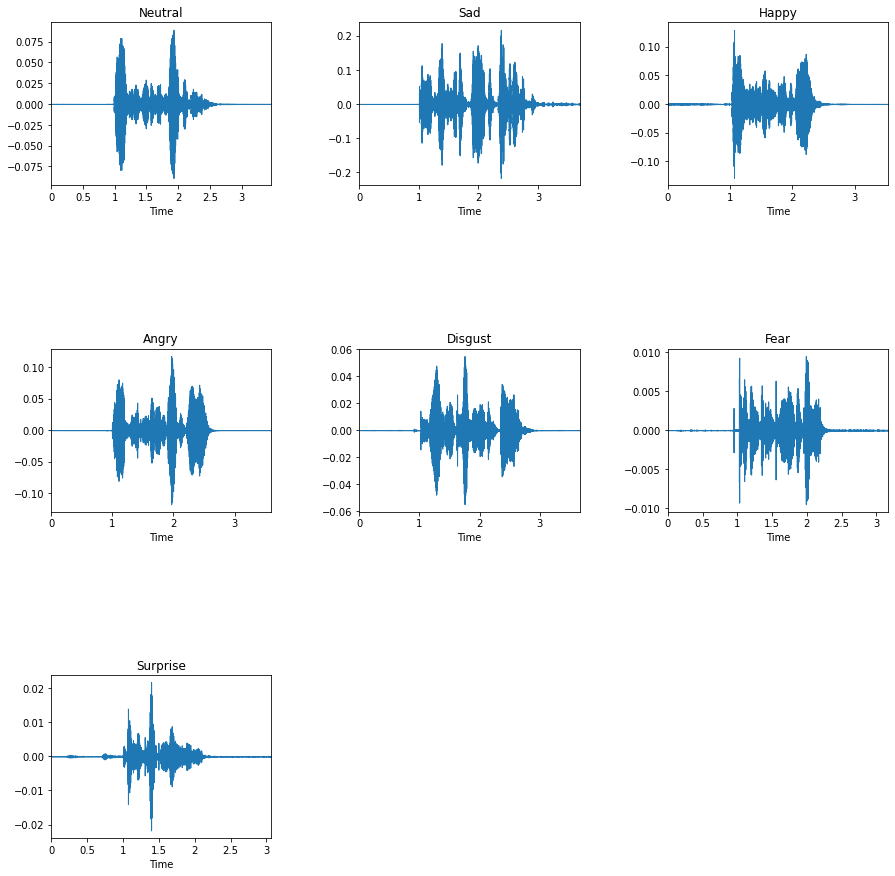

In [12]:
plot_all_emotion_waveforms('male')


### Comparativa de emociones para mujer

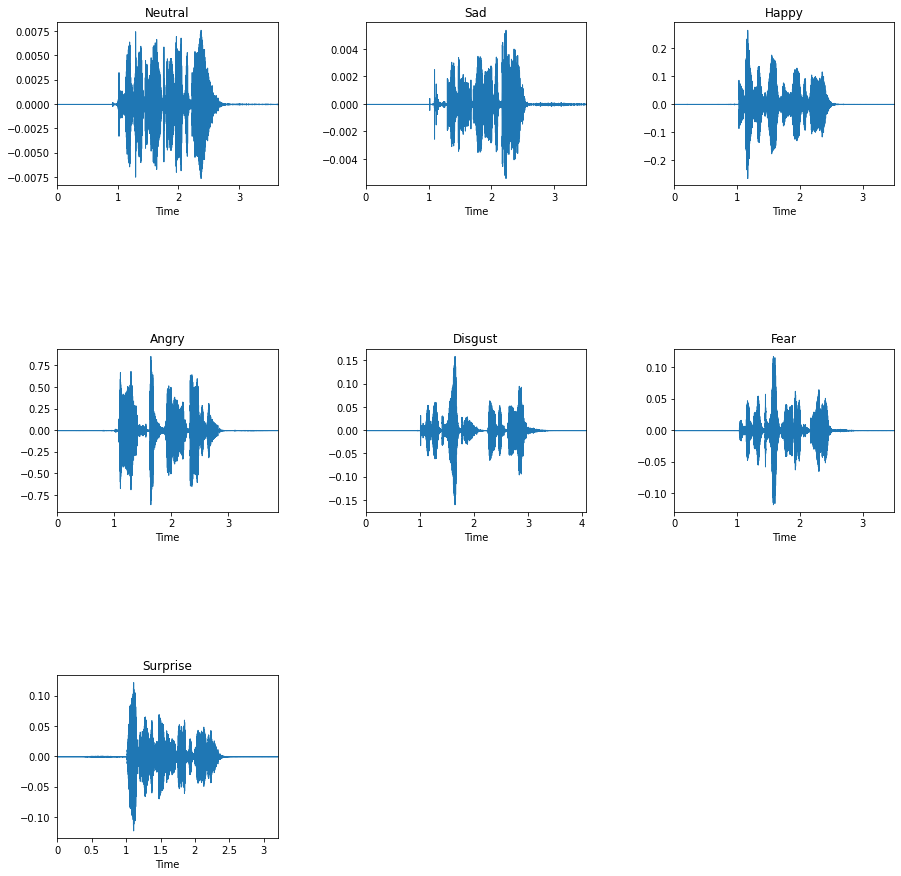

In [13]:
plot_all_emotion_waveforms('female')

# Extraccion de Caracteristicas

### Extracción de características con MFCC

In [14]:
def get_features(df):
  '''
  Extrae las caracteristicas de un conjunto de pistas de audio a 
  partir de un dataframe usando librosa
  @ Args
    df Dataframe que contiene el path donde se encuentra la pista de audio
  @ Return
   data Estructura que contiene las caracteristicas extraidas

  '''
  bar_data_range = tqdm(range(len(df)))
  data = pd.DataFrame(columns = ['data'])
  for index in bar_data_range:
    data_features = get_features_single_file(df.path[index])
    data.loc[index] = [data_features]

  return data


def get_features_single_file(pathfile):
  '''
  Extrae las caracteristicas  de una unica pista de audio usando MFCC 
  a traves de librosa.
  @ Args
    pathfile Path del archivo del que se extraeran las caracteristicas
  @ Return
    data_features

  '''
  X, sample_rate = librosa.load(pathfile, duration=2.5, sr=22050*2, offset=0.5)
  mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
  data_features = np.mean(mfcc, axis = 0)

  return data_features



def get_random_emotion(df, emotion):
  '''
  Devuelve el path de un archivo de audio aleatorio a partir de un dataframe
  @ Args
  @ Return
  '''
  if 'emotion' not in df:
    return -1

  aux_df = df[df['emotion'] == emotion]
  item = random.choice(aux_df.index.to_list())
  path = aux_df.path[item]

  return path

def plot_waves_comparative(df1, df2, df1_title = 'Wave 1', df2_title = 'Wave 2', title_ = 'Title'):
  '''
  Imprime la grafica de dos waveforms
  @ Args
  '''
  plt.figure(figsize=(20, 15))
  plt.subplot(3,1,1)
  plt.title(title_)
  plt.plot(df1, label= df1_title)
  plt.plot(df2, label= df2_title)
  plt.legend()


def plot_all_comparative_waveforms(rows = 3, cols = 3):

  labels = list(EnglishSpeech_df['emotion'].unique())
  features_dict = dict()
  for label in labels:
    # Female
    path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'female'], label)
    # female_feat = get_features_single_file(path)
    key = 'female_' + label
    features_dict[key] = get_features_single_file(path)
    # Male
    path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'male'], label)
    # male_feat = get_features_single_file(path)
    key = 'male_' + label
    features_dict[key] = get_features_single_file(path)

  # Mostramos las diferentes waveforms
  fig = plt.figure(figsize=(15,15))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  for i, label in enumerate(labels):
    key = 'female_' + label
    df_fem = features_dict[key]
    key = 'male_' + label
    df_mal = features_dict[key]
    fig.add_subplot(rows, cols, i+1)
    plt.title(label)
    plt.plot(df_fem, label= 'female')
    plt.plot(df_mal, label= 'male')
    plt.legend()



In [15]:
# Guardamos las caracteristicas a partir de la estructura que hemos construido antes
features_data = get_features(EnglishSpeech_df)
print(features_data)

100%|██████████| 1440/1440 [18:36<00:00,  1.29it/s]

                                                   data
0     [-66.05910681311283, -66.05910681311283, -66.0...
1     [-73.84224775864776, -73.84224775864776, -73.8...
2     [-61.85074892615189, -62.89585881547302, -63.8...
3     [-70.26853901183485, -70.26853901183485, -70.2...
4     [-69.05200902221408, -69.05200902221408, -69.0...
...                                                 ...
1435  [-59.85004278278616, -59.85004278278616, -59.8...
1436  [-58.23212314147993, -58.23212314147993, -58.2...
1437  [-56.94139761360669, -56.94139761360669, -56.9...
1438  [-48.669617015930115, -45.72232576407416, -46....
1439  [-55.25596532128967, -55.25596532128967, -55.1...

[1440 rows x 1 columns]


In [16]:
# features_data.head()
f_df = pd.DataFrame(features_data['data'].values.tolist())
f_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-65.682804,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-65.751525,-63.380963,-62.700762,-65.098389,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.002813,-61.924990,-59.585243,-56.340054,-54.956473,-55.591424,...,-55.764549,-58.545475,-55.988739,-56.975453,-61.780469,-65.383771,-63.935678,-63.328607,-62.011508,-61.251253,-62.367167,-62.563301,-61.352037,-63.539752,-64.852817,-61.058858,-60.734669,-62.970984,-65.925474,-66.059107,-66.059107,-65.233562,-64.616935,-65.550824,-66.059107,-66.059107,-65.296366,-61.711599,-60.360745,-60.373732,-57.540460,-55.827201,-57.742851,-59.797208,-60.976193,-62.663849,-64.574215,-63.783475,-61.517013,-58.217070
1,-73.842248,-73.842248,-73.842248,-73.720530,-73.842248,-73.842248,-73.842248,-73.304645,-72.807795,-73.842248,-73.842248,-73.318681,-65.748177,-64.292677,-63.901078,-62.007441,-61.668209,-60.353570,-62.795679,-71.039792,-67.588894,-70.090082,-71.926079,-72.205903,-73.842248,-71.767055,-69.865594,-65.621540,-62.510488,-60.178302,-61.991925,-64.299289,-65.288956,-67.775197,-66.402571,-64.903643,-62.787173,-58.825620,-54.061961,-53.111848,...,-30.143039,-30.706512,-30.394375,-29.729416,-30.308895,-29.539308,-30.008672,-29.881324,-30.892699,-33.100491,-30.836923,-30.755795,-30.185336,-31.663189,-33.846000,-34.118854,-36.499844,-38.370596,-39.913241,-41.742887,-42.856285,-43.770604,-44.719072,-45.199141,-46.888341,-48.836188,-49.847429,-49.986943,-49.796782,-51.918861,-51.597118,-50.530498,-53.475499,-54.207876,-51.526096,-52.561076,-54.772149,-56.335018,-57.500893,-56.567900
2,-61.850749,-62.895859,-63.831462,-60.553468,-60.822610,-62.074268,-64.890057,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-63.680493,-59.563391,-59.069228,-62.143885,-62.432298,-64.842635,-65.390719,-65.390719,-63.870670,-61.361367,-59.707895,-59.798948,-62.271982,-60.550753,-58.221989,-58.359528,-60.649240,-53.255684,-51.225755,-49.681643,-51.877787,-56.027065,-57.659992,-58.432911,-58.608313,-60.930635,-64.419700,-58.210065,...,-53.209364,-54.153309,-52.783723,-53.129264,-57.196295,-55.771369,-55.110695,-57.924317,-56.827615,-57.973215,-56.144128,-53.264212,-55.031011,-58.032765,-62.374458,-63.339923,-59.325737,-58.808514,-62.785079,-63.299223,-63.523276,-64.284761,-64.732945,-61.391405,-60.566310,-61.249635,-64.318772,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719
3,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.001543,-69.981668,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-66.097257,-63.398196,-68.260740,-70.268539,-69.666078,-68.817977,-66.116414,-63.903822,-68.622377,-70.268539,-69.642827,-68.421043,-70.044980,-67.233440,-66.351326,-68.504274,-66.578332,-62.981783,-62.694348,-65.907465,...,-40.011754,-39.581405,-41.080829,-41.835033,-43.329960,-44.811618,-46.607579,-45.475890,-48.727752,-51.779517,-51.438683,-52.644333,-54.618240,-56.557264,-56.229717,-53.642981,-52.772164,-51.569217,-54.047658,-55.942868,-54.383812,-54.098568,-52.374527,-51.011086,-53.335382,-55.216554,-57.184214,-60.705847,-57.998865,-57.543835,-58.802936,-57.448360,-58.897438,-58.751929,-57.406579,-60.079306,-63.427680,-62.639439,-61.083599,-60.235444
4,-69.052009,-69.052009,-69.052009,-69.052009,-69.052009,-68.755513,-69.052009,-69.052009,-69.052009,-68.359836,-68.879418,-69.052009,-68.494070,-67.110674,-66.995148,-68.018825,-66

In [17]:
features_complete_df = pd.concat((f_df, EnglishSpeech_df['gender'], EnglishSpeech_df['emotion']), axis = 1)
features_complete_df = features_complete_df.fillna(0)

# Barajamos las filas para imrpimir una muestra 
random_aux = shuffle(features_complete_df)
random_aux.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,gender,emotion
1178,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,-64.177598,...,-45.568566,-44.647581,-45.059808,-46.972249,-47.252876,-47.964726,-48.164108,-45.768064,-45.220304,-45.955066,-47.089773,-45.250367,-44.856562,-46.533807,-43.187541,-40.649524,-41.099071,-42.538625,-44.820940,-45.404221,-47.177027,-51.855580,-50.831315,-52.153413,-53.186736,-56.148097,-58.303343,-59.358259,-58.869073,-58.211374,-60.470173,-62.211616,-62.130601,-63.644241,-64.177598,-61.998213,-61.252309,-58.763876,female,fear
1342,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.409559,-59.433063,-59.643841,-60.450322,-60.458851,-59.426009,-57.685398,-56.590183,-55.777030,-55.404036,-51.860030,-50.213764,...,-56.339113,-54.991319,-55.776914,-57.813244,-57.138018,-57.990402,-59.494158,-59.686001,-59.066375,-56.656000,-55.921071,-57.518520,-57.897191,-60.147042,-60.458851,-60.458851,-60.458851,-60.458851,-60.458851,-60.088576,-59.761089,-60.419390,-60.327914,-59.858245,-60.231787,-60.373742,-60.458851,-60.422820,-60.458851,-60.458851,-60.458851,-60.458851,-60.192259,-59.208677,-57.310191,-55.105114,-54.712631,-55.621733,male,happy
514,-41.047330,-41.270791,-40.987831,-41.232109,-42.389998,-43.125676,-43.653656,-44.034985,-43.266164,-42.934558,-42.928342,-42.029517,-41.813296,-42.521797,-43.083534,-42.108463,-42.100030,-43.072699,-42.801012,-42.834167,-43.216774,-43.125309,-43.761097,-43.312905,-43.128177,-43.496379,-43.291644,-43.153284,-42.909462,-39.659270,-38.026711,-39.182309,-38.454810,-34.568740,-31.812614,-34.101520,-39.064903,-38.921460,-38.914574,-39.445347,...,-14.677956,-14.819796,-14.920712,-14.981404,-14.761267,-15.088243,-16.034975,-17.182388,-18.113813,-18.639327,-18.144225,-16.622002,-18.124090,-20.832690,-20.042211,-19.480480,-17.928895,-17.463517,-18.591148,-19.756905,-17.810477,-16.531119,-16.322497,-14.768985,-13.596026,-13.575397,-14.182018,-13.984538,-14.269270,-14.635455,-14.742995,-15.981150,-15.483739,-16.632142,-17.282018,-18.546068,-19.251348,-21.390247,male,angry
960,-49.251483,-47.741671,-49.673832,-50.765729,-51.802235,-51.358459,-51.993849,-51.297449,-49.915823,-51.692372,-50.621297,-49.753267,-50.847158,-50.299161,-50.179670,-50.957929,-52.096002,-50.879185,-52.706436,-51.054504,-48.331558,-48.940324,-48.816623,-48.637217,-49.683000,-48.832234,-49.915768,-50.517494,-50.681126,-53.177385,-51.665253,-51.824413,-50.450129,-50.357365,-52.354491,-52.808255,-52.973492,-54.473907,-50.388549,-47.149428,...,-25.234090,-26.325076,-28.157370,-30.092469,-31.308708,-33.368674,-33.226204,-36.391032,-38.975804,-40.869437,-38.545366,-39.248176,-41.925164,-43.097348,-41.489777,-45.054223,-44.805017,-44.109677,-46.538801,-45.696487,-44.977805,-45.530887,-47.708330,-51.499904,-50.263987,-45.378298,-46.067504,-45.522146,-45.513687,-45.862756,-46.302909,-49.885502,-48.920194,-49.577968,-49.002507,-47.466917,-47.604165,-46.976848,male,neutral
633,-47.693280,-47.514737,-47.105554,-47.693280,-47.693280,-47.693280,-47.693280,-47.693280,-47.693280,-47.693280,-47.693280,-47.693280,-47.693280,-47.693280,-47.693280,-46.590243,-46.644868,-46.753545,-47

### Division del dataframe
Vamos a dividir el dataframe por el genero, para comprobar como afecta este a la prosodia en la voz femenina y masculina por separadas, dadas las mismas emociones en el analisis

In [18]:
male_features_df = features_complete_df[(features_complete_df['gender'] == 'male')]
female_features_df = features_complete_df[(features_complete_df['gender'] == 'female')]

### Comparativa
Ahora que podemos extraer las caracteristicas de las señales, vamos a comparar la misma emocion en la voz femenina y la masculina.


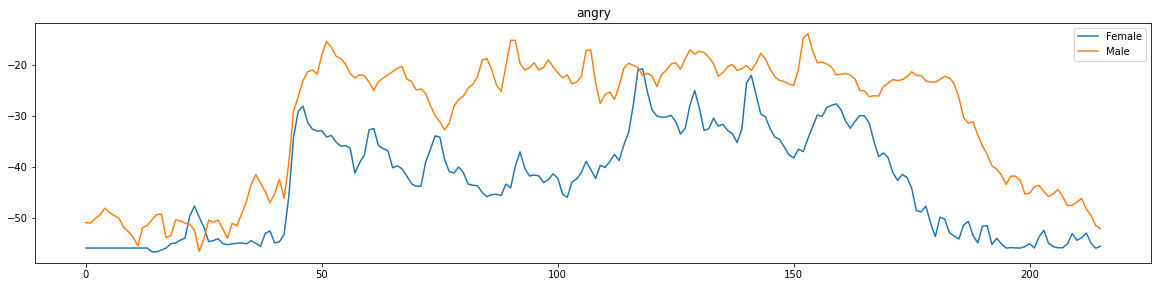

In [19]:
# Extraemos una muestra aleatoria para la emocion: enfado 
# Female
path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'female'], 'angry')
female_feat = get_features_single_file(path)
# print(len(female_feat))
# Male
path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'male'], 'angry')
male_feat = get_features_single_file(path)
# print(len(male_feat))

plot_waves_comparative(female_feat, male_feat, "Female", "Male", "angry")



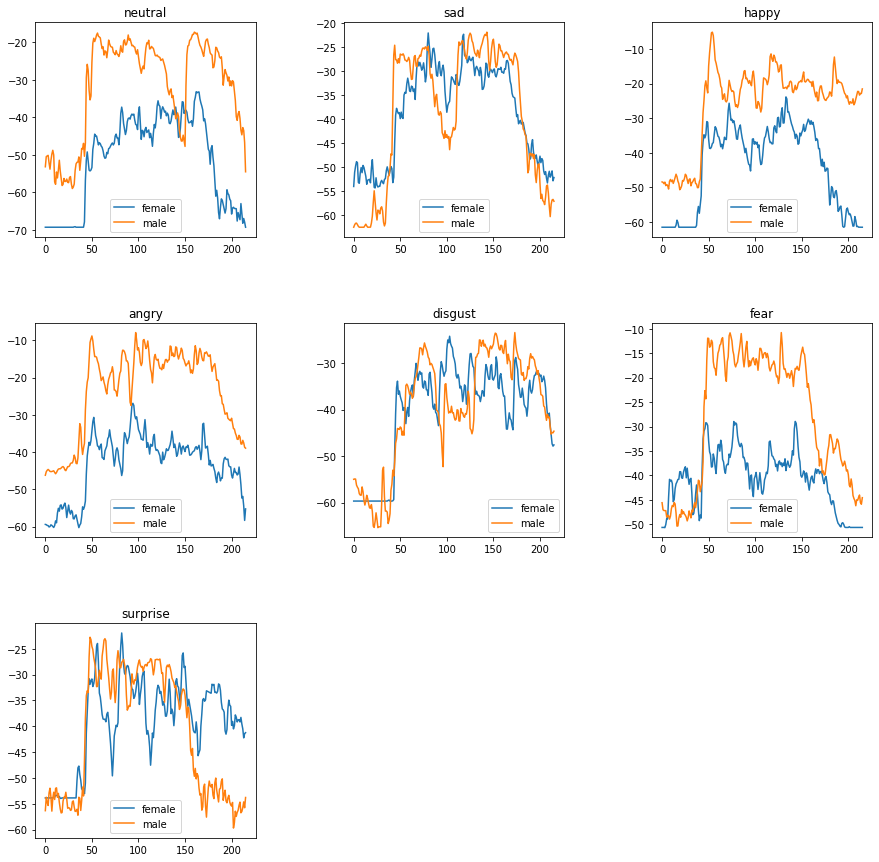

In [20]:
plot_all_comparative_waveforms()

# Preparación de los datos


In [58]:
def split_training_test(df, n_splits_=1, test_size_=0.25, train_size_=None):
  '''
  Divide el dataset en entrenamieto y test utilizando StratifiedShuffleSplit
  @ Args

  @ Return
  '''
  X = df.drop(['gender', 'emotion'], axis=1)
  Y = df.emotion
  test_train_stratified = StratifiedShuffleSplit(n_splits = n_splits_, test_size = test_size_, random_state=12)
  for train_index, test_index in test_train_stratified.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

  return X_train, X_test, Y_train, Y_test
  # return train_test_split(X, Y, stratify = Y, test_size=0.25)#X_train, X_test, Y_train, Y_test


def data_normalization(val_train, val_test):
  '''
  Normaliza los datos mejorando la precision y la velocidad del proceso de entrenamiento
  '''
  # Now because we are mixing up a few different data sources, it would be wise to normalise the data. 
  # This is proven to improve the accuracy and speed up the training process. Prior to the discovery of this solution in the embrionic years of neural network, 
  # the problem used to be know as "exploding gradients".
  mean = np.mean(val_train, axis=0)
  std = np.std(val_train, axis=0)

  X_train = (val_train - mean)/std
  X_test = (val_test - mean)/std

  return X_train, X_test


def data_to_categorical(x_train_norm, y_train, x_test_norm, y_test):
  '''
  Categoriza los datos y los formatea para su uso con keras. Asume que x_train y x_test estan normalizados.
  
  '''
  # Lets few preparation steps to get it into the correct format for Keras 
  # Preparamos los datos para la categorizacion
  x_train_norm = np.array(x_train_norm)
  y_train = np.array(y_train)
  x_test_norm = np.array(x_test_norm)
  y_test = np.array(y_test)

  # One hot encode 
  label_encoder = LabelEncoder()
  y_train = np_utils.to_categorical(label_encoder.fit_transform(y_train))
  y_test = np_utils.to_categorical(label_encoder.fit_transform(y_test))

  # # Pickel the lb object for future use 
  # filename = 'labels'
  # outfile = open(filename,'wb')
  # pickle.dump(label_encoder, outfile)
  # outfile.close()

  # print(x_train_norm.shape)
  # print(label_encoder.classes_)

  return x_train_norm, y_train, x_test_norm, y_test, label_encoder



## Division de los datos en entrenamiento y test

In [22]:
# NOTA: Aqui estoy comprobando los datos que me da si divido entrenamiento y test con split de toda la vida

# # female_X_train, female_X_test, female_Y_train, female_Y_test =split_training_test(female_features_df)
# female_X_train.head()
# print(918 in female_X_train.index)

In [59]:
X_train, X_test, Y_train, Y_test = split_training_test(features_complete_df)
X_train.head()
print(X_train.shape)

(1080, 216)


In [60]:
# Comprobamos la distribución de las clases (emociones)
Y_train.value_counts()

neutral     216
disgust     144
angry       144
happy       144
surprise    144
fear        144
sad         144
Name: emotion, dtype: int64

In [61]:
# Comprobamos que no hay valores NaN
X_train.isna().sum().sum()

0

### Normalizacion de los datos


In [62]:
X_train_norm, X_test_norm = data_normalization(X_train, X_test)
print(features_complete_df.shape)

# Comprobamos imprimiendo una muestra de los datos
indx = random.randint(0, len(features_complete_df))
X_train[indx:indx+10]

(1440, 218)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
436,-54.162344,-53.225358,-54.675122,-55.004067,-54.083433,-53.164879,-52.788070,-53.056361,-53.993234,-57.787618,-58.036651,-56.708616,-53.521937,-54.875138,-53.658540,-51.337626,-52.856497,-54.492953,-57.134392,-56.530989,-56.732262,-55.932144,-54.820118,-54.286827,-56.373606,-54.473239,-52.258817,-53.864056,-54.113459,-53.548712,-52.358322,-49.402014,-52.784827,-52.019110,-51.366292,-48.067901,-46.812454,-47.682349,-48.108515,-49.605746,...,-35.051468,-36.452315,-35.633264,-36.247040,-37.000431,-37.299306,-36.039542,-33.968855,-34.706319,-36.621738,-38.972717,-38.559064,-37.674895,-39.818529,-38.641345,-36.222807,-35.897220,-34.244568,-34.790475,-34.248710,-36.106247,-37.385776,-38.920751,-39.903419,-39.087315,-40.257356,-42.066741,-42.808387,-43.331557,-41.299775,-39.240139,-39.111297,-39.152139,-36.930862,-36.521805,-37.254115,-38.065537,-39.441663,-39.029793,-40.356724
1177,-31.164050,-28.618379,-24.918763,-24.495816,-24.847457,-25.157015,-24.030976,-25.512754,-27.974693,-31.118806,-30.575057,-32.165867,-33.398211,-33.816877,-34.153777,-35.070190,-34.883159,-35.568228,-35.916779,-36.079255,-35.809098,-35.119569,-35.381347,-35.911315,-35.242838,-35.368498,-36.235443,-36.730550,-36.554812,-36.619174,-36.848710,-36.862481,-36.560531,-36.162999,-35.923535,-35.650415,-35.435632,-35.594543,-34.594179,-33.189230,...,-22.556140,-25.946846,-29.665390,-30.528144,-31.633993,-31.317358,-30.889052,-30.654282,-31.951176,-31.291873,-31.274039,-32.010458,-33.152067,-33.466016,-34.715240,-35.530168,-35.921520,-34.846652,-35.139607,-35.613387,-35.710296,-35.829124,-35.685260,-35.542658,-35.304792,-35.252001,-35.472457,-35.679770,-35.886777,-36.117731,-36.318652,-36.448312,-36.468418,-36.526566,-36.526566,-36.526566,-36.526566,-36.526566,-36.526566,-36.526566
503,-70.023314,-70.949312,-73.168379,-64.959415,-64.918199,-66.996154,-62.869469,-65.107494,-67.320243,-64.601978,-61.332428,-62.529068,-68.042195,-62.992362,-63.431278,-74.388749,-77.774066,-68.501235,-65.690824,-65.458800,-63.156009,-64.229855,-63.603317,-63.358968,-65.821781,-70.687587,-68.102319,-63.663741,-63.618241,-65.090042,-63.845573,-62.182151,-63.095367,-65.482384,-61.052775,-61.890610,-62.576439,-57.730539,-58.900399,-57.497151,...,-55.586501,-55.124867,-54.835392,-54.630067,-53.822734,-55.111450,-57.847337,-58.260116,-56.224389,-51.839459,-52.486332,-55.615748,-56.160224,-55.495283,-56.360729,-57.015434,-58.744329,-60.038377,-58.130941,-56.077358,-53.922725,-54.958285,-60.704876,-59.863994,-56.474785,-54.174663,-56.002230,-57.175725,-58.773829,-57.590357,-57.252654,-58.139483,-58.959825,-63.121851,-61.281527,-58.377608,-58.458560,-58.863266,-57.738483,-57.170706
153,-43.531425,-44.457811,-45.280159,-45.536332,-45.076282,-45.133707,-44.699766,-45.069400,-45.377016,-45.129085,-44.375778,-44.137201,-43.676065,-43.095350,-43.291520,-43.044388,-43.863612,-44.441285,-46.106452,-45.706888,-46.242532,-44.434029,-43.739253,-43.597928,-42.840995,-43.997779,-45.185395,-45.460842,-44.989114,-44.133866,-42.917940,-43.950060,-45.266690,-45.217672,-44.831869,-45.401368,-46.338541,-45.896606,-44.281595,-40.493867,...,-9.932666,-10.411591,-10.354387,-9.888866,-10.227647,-9.694229,-10.536162,-9.579469,-9.622768,-11.046654,-13.801257,-13.489560,-14.678800,-11.883071,-9.663282,-11.400915,-12.203140,-13.220592,-14.362711,-16.664219,-13.501702,-10.557900,-11.500794,-12.924038,-17.530002,-19.938552,-19.573300,-20.001696,-23.763844,-19.392570,-16.685081,-16.153703,-14.737007,-17.859093,-21.370800,-22.586197,-21.505827,-21.101690,-14.148569,-5.777656
77,-50.220719,-50.220719,-50.399290,-50.745857,-51.077468,-50.711124,-49.992283,-48.946691,-47.252212,-45.801733,-46.502156,-46.834533,-45.180197,-45.422641,-45.066065,-44.818892,

### Categorizacion de los datos

In [64]:
X_train, Y_train, Y_test, Y_test, labels_whole = data_to_categorical(X_train_norm, Y_train, X_test_norm, Y_test)

In [66]:
print(labels_whole.classes_)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


### Cambio de dimension

In [67]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print(X_train.shape)

(1080, 216, 1)


### Preparación de los datos para _Female_

In [71]:
# 1. Division de los datos: Entrenamiento y Test
female_X_train, female_X_test, female_Y_train, female_Y_test =split_training_test(female_features_df) # with StratifiedShuffleSplit

# 2. Normalizacion
x_train_female_norm, x_test_female_norm = data_normalization(female_X_train, female_X_test)
print(x_train_female_norm.shape)

# 3. Categorización
female_X_train, female_X_test, female_Y_train, female_Y_test, labels_female = data_to_categorical(x_train_female_norm, female_Y_train, x_test_female_norm, female_Y_test)
print(labels_female.classes_)

# 4. Cambio de Dimensión
X_train_female = np.expand_dims(female_X_train, axis=2)
X_test_female = np.expand_dims(female_X_test, axis=2)

(540, 216)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


### Preparación de los datos para _Male_


In [73]:
# 1. Division de los datos: Entrenamiento y Test
male_X_train, male_X_test, male_Y_train, male_Y_test =split_training_test(male_features_df)
male_X_train.head()

# 2. Normalizacion
x_train_male_norm, x_test_male_norm = data_normalization(male_X_train, male_X_test)
print(x_train_male_norm.shape)

# 3. Categorización
male_X_train, male_X_test, male_Y_train, male_Y_test, labels_male = data_to_categorical(x_train_male_norm, male_Y_train, x_test_male_norm, male_Y_test)
print(labels_male.classes_)
# 4. Cambio de Dimensión
X_train_male = np.expand_dims(X_train, axis=2)
X_test_male = np.expand_dims(X_test, axis=2)

(540, 216)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


# El modelo
## Diseño del modelo

In [74]:
def model_cnn(x_train, n_classes):
  '''
  '''
  model = Sequential()
  model.add(Conv1D(256, 8, padding='same',input_shape=(x_train.shape[1],1)))  
  model.add(Activation('relu'))
  model.add(Conv1D(256, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 8, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(128, 8, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(128, 8, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(128, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(64, 8, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 8, padding='same'))
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(n_classes)) # Target class number
  model.add(Activation('softmax'))

  return model

# def model_rnn():


## Compilación del modelo

In [75]:
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

model = model_cnn(X_train, Y_train.shape[1])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 216, 256)          2304      
_________________________________________________________________
activation_9 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_2 (Batch (None, 216, 256)          1024      
_________________________________________________________________
activation_10 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 256)          

In [76]:
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt,
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, 
                        batch_size=16, 
                        epochs=100, 
                        validation_data=(X_test, Y_test))

Epoch 1/100
68/68 [==============================] - 23s 341ms/step - loss: 1.9419 - accuracy: 0.2213 - val_loss: 2.0026 - val_accuracy: 0.2000
Epoch 2/100
68/68 [==============================] - 23s 339ms/step - loss: 1.8288 - accuracy: 0.2713 - val_loss: 2.2471 - val_accuracy: 0.2000
Epoch 3/100
68/68 [==============================] - 23s 342ms/step - loss: 1.7891 - accuracy: 0.2917 - val_loss: 2.9037 - val_accuracy: 0.2000
Epoch 4/100
68/68 [==============================] - 23s 338ms/step - loss: 1.7417 - accuracy: 0.3250 - val_loss: 4.0926 - val_accuracy: 0.2000
Epoch 5/100
68/68 [==============================] - 27s 398ms/step - loss: 1.7157 - accuracy: 0.3444 - val_loss: 5.7743 - val_accuracy: 0.2194
Epoch 6/100
68/68 [==============================] - 23s 338ms/step - loss: 1.6757 - accuracy: 0.3694 - val_loss: 8.0820 - val_accuracy: 0.2111
Epoch 7/100
68/68 [==============================] - 23s 340ms/step - loss: 1.6523 - accuracy: 0.3917 - val_loss: 10.4313 - val_accuracy

### Persistencia del modelo
Guardamos el modelo para un uso posterior sin necesidad de volverlo a entrenar


In [78]:
# detectar que modelo acaba de ejecutarse para guardarlo automaticamente?
model.save('model_english_SER.h5')

## Validación del modelo

3/3 [==============================] - 1s 335ms/step - loss: 38.1310 - accuracy: 0.1889
Loss, Accuracy:  [38.13103103637695, 0.18888889253139496]


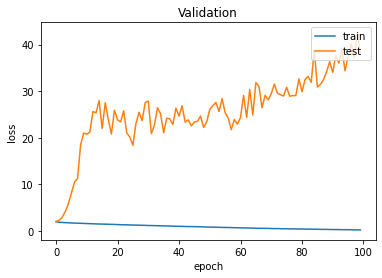

In [79]:
# Evaluamos contra test
score = model.evaluate(X_test, Y_test, batch_size=128)
print("Loss, Accuracy: ", score)

# Mostramos la grafica del loss y accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Predicción

In [35]:
model.predict(X_test, batch_size = 16, verbose = 1)